## Access SOOP CO2 data in Parquet

A jupyter notebook to show how to access and plot SOOP CO2 data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "vessel_co2_delayed_qc"

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

In [ ]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Location of the parquet dataset

In [3]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
polygon: string
platform_code: string


## List unique partition values

In [5]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'platform_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['ZMFR', 'VLMJ']
CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 18.9 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

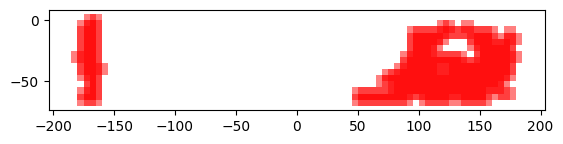

In [6]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2008, 1, 1, 11, 0), datetime.datetime(2024, 4, 1, 11, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [8]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'analysis_time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 999999.0,
  'ancillary_variables': 'TIME_quality_control'},
 'TIME_quality_control': {'type': 'float',
  'standard_name': 'time status_flag',
  'long_name': 'Quality Control flag for time',
  'quality_control_conventions': 'WOCE quality control procedure',
  'valid_min': 2,
  'valid_max': 4,
  'flag_values': [2, 3, 4],
  'flag_meanings': 'good questionable bad',
  'references': 'Pierrot,D. et al. 2009, Recommendations for Autonomous Underway pCO2 Measuring Systems and Data Reduction Routines, Deep-Sea Research II, doi:10.1016/j.dsr2.2008.12.005',
  'ancillary_variables': 'SUBFLAG'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'geographical coordinates, WGS84 projection',
  'ancillary_variables'

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [9]:
filter_time = create_time_filter(parquet_ds, date_start='2020-12-23 10:14:00', date_end='2024-01-01 07:50:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)


filter = filter_geo & filter_time

In [10]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10199 entries, 0 to 10198
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   TIME                                       10199 non-null  datetime64[ns]
 1   TIME_quality_control                       10199 non-null  float32       
 2   LATITUDE                                   10199 non-null  float64       
 3   LATITUDE_quality_control                   10199 non-null  float32       
 4   LONGITUDE                                  10199 non-null  float64       
 5   LONGITUDE_quality_control                  10199 non-null  float32       
 6   TEMP                                       10199 non-null  float64       
 7   TEMP_quality_control                       10199 non-null  float32       
 8   TEMP_2                                     10196 non-null  float64       
 9   TEMP_2_quality_co

In [11]:
df

,TIME,TIME_quality_control,LATITUDE,LATITUDE_quality_control,LONGITUDE,LONGITUDE_quality_control,TEMP,TEMP_quality_control,TEMP_2,TEMP_2_quality_control,...,H2OFLOW,H2OFLOW_quality_control,SUBFLAG,TYPE,cruise_id,vessel_name,filename,timestamp,polygon,platform_code
0,2021-05-10 18:05:01.000000000,2.0,-33.999871,2.0,151.395629,2.0,20.435,2.0,20.66,2.0,...,2.09,2.0,NaN,EQU,IN2021_V03,RV Investigator,IMOS_SOOP-CO2_GST_20210508T033536Z_VLMJ_FV01.nc,1619827200,0103000000010000000500000000000000002062400000...,VLMJ
1,2021-05-10 18:06:23.000000000,2.0,-33.996769,2.0,151.399301,2.0,20.429,2.0,20.66,2.0,...,2.09,2.0,NaN,EQU,IN2021_V03,RV Investigator,IMOS_SOOP-CO2_GST_20210508T033536Z_VLMJ_FV01.nc,1619827200,0103000000010000000500000000000000002062400000...,VLMJ
2,2021-05-10 18:07:41.999999744,2.0,-33.993654,2.0,151.402956,2.0,20.438,2.0,20.67,2.0,...,2.09,2.0,NaN,EQU,IN2021_V03,RV Investigator,IMOS_SOOP-CO2_GST_20210508T033536Z_VLMJ_FV01.nc,1619827200,0103000000010000000500000000000000002062400000...,VLMJ
3,2021-05-10 18:09:03.999999744,2.0,-33.990543,2.0,151.406601,2.0,20.428,2.0,20.66,2.0,...,2.09,2.0,NaN,EQU,IN2021_V03,RV Investigator,IMOS_SOOP-CO2_GST_20210508T033536Z_VLMJ_FV01.nc,1619827200,0103000000010000000500000000000000002062400000...,VLMJ
4,2021-05-10 18:10:25.000000000,2.0,-33.987426,2.0,151.410262,2.0,20.432,2.0,20.66,2.0,...,2.09,2.0,NaN,EQU,IN2021_V03,RV Investigator,IMOS_SOOP-CO2_GST_20210508T033536Z_VLMJ_FV01.nc,1619827200,0103000000010000000500000000000000002062400000...,VLMJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10194,2023-11-01 16:37:56.000000000,2.0,-33.852700,2.0,151.471700,2.0,20.172,2.0,20.45,2.0,...,2.12,2.0,NaN,EQU,IN2023_V06,RV Investigator,IMOS_SOOP-CO2_GST_20231009T002809Z_VLMJ_FV01.nc,1698796800,0103000000010000000500000000000000002062400000...,VLMJ
10195,2023-11-01 16:39:14.000000000,2.0,-33.850300,2.0,151.470400,2.0,20.164,2.0,20.45,2.0,...,2.12,2.0,NaN,EQU,IN2023_V06,RV Investigator,IMOS_SOOP-CO2_GST_20231009T002809Z_VLMJ_FV01.nc,1698796800,0103000000010000000500000000000000002062400000...,VLMJ
10196,2023-11-01 16:40:34.000000000,2.0,-33.847900,2.0,151.469200,2.0,20.147,2.0,20.43,2.0,...,2.12,2.0,NaN,EQU,IN2023_V06,RV Investigator,IMOS_SOOP-CO2_GST_20231009T002809Z_VLMJ_FV01.nc,1698796800,0103000000010000000500000000000000002062400000...,VLMJ
10197,2023-11-01 16:41:54.000000000,2.0,-33.845800,2.0,151.468100,2.0,20.129,2.0,20.42,2.0,...,2.12,2.0,NaN,EQU,IN2023_V06,RV Investigator,IMOS_SOOP-CO2_GST_20231009T002809Z_VLMJ_FV01.nc,1698796800,0103000000010000000500000000000000002062400000...,VLMJ


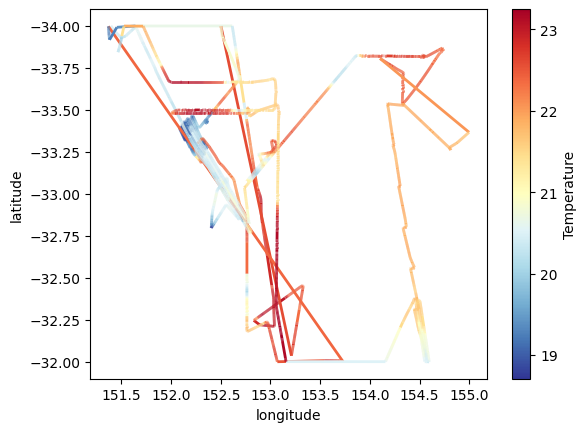

In [12]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()

## Create a TIME and scalar/number filter

In [13]:
filter_time = create_time_filter(parquet_ds, date_start='2020-01-31 10:14:00', date_end='2022-02-01 07:50:00')

expr_1 = pc.field('platform_code') == pa.scalar("VLMJ")
filter = expr_1 & filter_time

In [14]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244944 entries, 0 to 244943
Data columns (total 44 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   TIME                                       244944 non-null  datetime64[ns]
 1   TIME_quality_control                       244944 non-null  float32       
 2   LATITUDE                                   244944 non-null  float64       
 3   LATITUDE_quality_control                   244944 non-null  float32       
 4   LONGITUDE                                  244944 non-null  float64       
 5   LONGITUDE_quality_control                  244944 non-null  float32       
 6   TEMP                                       244680 non-null  float64       
 7   TEMP_quality_control                       244944 non-null  float32       
 8   TEMP_2                                     244780 non-null  float64       
 9   TEMP

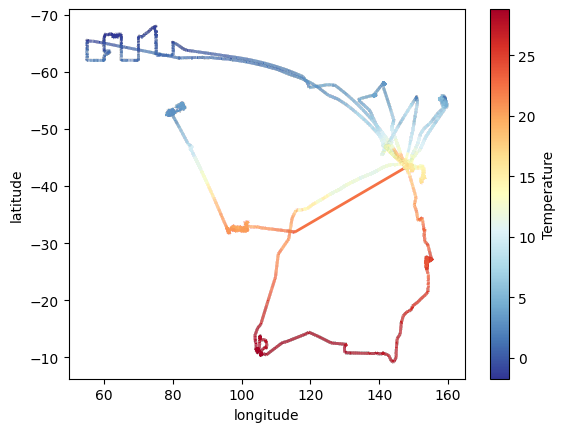

In [15]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()